<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_AE/LSTM_AE_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 8.01 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 16 09:22:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Amazon'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 5.4MB/s 
     |████████████████████████████████| 102kB 13.7MB/s 
     |████████████████████████████████| 143kB 47.4MB/s 
     |████████████████████████████████| 174kB 49.1MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(LSTM(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(LSTM(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: e40ob5op
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_AE/sweeps/e40ob5op


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: bjwk3tn2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
31/31 [==============================] - 25s 72ms/step - loss: 0.0685 - mean_squared_error: 0.0685 - mean_absolute_error: 0.1716 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1338
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0753 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1051
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0769 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0677
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0608 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0819
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0072 - mean_squared

epoch,73
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.02862
val_loss,0.00692
val_mean_squared_error,0.00692
val_mean_absolute_error,0.07305
_runtime,63
_timestamp,1626368412
_step,73
best_val_loss,0.00314


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▃▂▂▃█▂▇▂▂▂▂▂▂▁▆▁▂▁▁▁▃▁▁▂▁▂▁▁▁▁▁▁▃▂
val_mean_squared_error,█▅▃▂▂▂▃▂▂▃█▂▇▂▂▂▂▂▂▁▆▁▂▁▁▁▃▁▁▂▁▂▁▁▁▁▁▁▃▂
val_mean_absolute_error,█▆▄▃▂▂▃▂▂▃█▂▇▂▂▂▃▂▃▁▆▂▃▁▁▂▃▁▁▃▁▂▁▁▁▁▁▂▃▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dqh0kv6f with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 16s 305ms/step - loss: 2345.7003 - mean_squared_error: 2345.7003 - mean_absolute_error: 3.7089 - val_loss: 0.2473 - val_mean_squared_error: 0.2473 - val_mean_absolute_error: 0.4556
Epoch 2/100
16/16 [==============================] - 3s 187ms/step - loss: 0.1211 - mean_squared_error: 0.1211 - mean_absolute_error: 0.2715 - val_loss: 0.0766 - val_mean_squared_error: 0.0766 - val_mean_absolute_error: 0.2414
Epoch 3/100
16/16 [==============================] - 3s 193ms/step - loss: 0.3256 - mean_squared_error: 0.3256 - mean_absolute_error: 0.3030 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - val_mean_absolute_error: 0.3053
Epoch 4/100
16/16 [==============================] - 3s 182ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1391 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0981
Epoch 5/100
16/16 [==============================] - 3s 180ms/step - loss: 0.0220 - m

epoch,19
loss,0.07484
mean_squared_error,0.07484
mean_absolute_error,0.2235
val_loss,1.36351
val_mean_squared_error,1.36351
val_mean_absolute_error,1.09268
_runtime,77
_timestamp,1626368501
_step,19
best_val_loss,0.01275


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂█
val_mean_squared_error,▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂█
val_mean_absolute_error,▄▂▃▁▁▁▁▁▁▁▁▁▁▁▂▁▁▃▃█
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: kcokdu10 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 10s 413ms/step - loss: 0.1754 - mean_squared_error: 0.1754 - mean_absolute_error: 0.3258 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - val_mean_absolute_error: 0.2803
Epoch 2/100
8/8 [==============================] - 2s 193ms/step - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1443 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.1001
Epoch 3/100
8/8 [==============================] - 2s 195ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0863 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0856
Epoch 4/100
8/8 [==============================] - 1s 180ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0674 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.1017
Epoch 5/100
8/8 [==============================] - 1s 186ms/step - loss: 0.0064 - mean_squared_erro

epoch,12
loss,0.00641
mean_squared_error,0.00641
mean_absolute_error,0.05726
val_loss,0.03814
val_mean_squared_error,0.03814
val_mean_absolute_error,0.17224
_runtime,32
_timestamp,1626368564
_step,12
best_val_loss,0.01006


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▂▁▁▁▁
val_loss,█▁▁▁▂▁▁▁▂▃▂▂▃
val_mean_squared_error,█▁▁▁▂▁▁▁▂▃▂▂▃
val_mean_absolute_error,█▂▁▂▂▂▁▁▂▃▂▃▄
_runtime,▁▂▂▃▃▄▅▅▆▆▇██
_timestamp,▁▂▂▃▃▄▅▅▆▆▇██
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: hj9pky1e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 8s 65ms/step - loss: 0.0787 - mean_squared_error: 0.0787 - mean_absolute_error: 0.1993 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0942
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0368 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0728
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0299 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0732
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0295 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0765
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - mean_squared_

epoch,99
loss,0.00073
mean_squared_error,0.00073
mean_absolute_error,0.02017
val_loss,0.00339
val_mean_squared_error,0.00339
val_mean_absolute_error,0.04435
_runtime,55
_timestamp,1626368650
_step,99
best_val_loss,0.00339


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▆▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁
val_mean_squared_error,█▅▅▆▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁
val_mean_absolute_error,█▅▅▅▄▄▄▃▃▃▃▃▃▂▂▄▂▂▂▂▂▂▂▃▂▂▂▂▂▁▂▁▁▂▂▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hrek87cm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 7s 224ms/step - loss: 0.1222 - mean_squared_error: 0.1222 - mean_absolute_error: 0.2655 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - val_mean_absolute_error: 0.2235
Epoch 2/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1458 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1099
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.1067 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1122
Epoch 4/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0599 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0748
Epoch 5/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0046 - mean_squared_error: 0.

epoch,78
loss,0.00131
mean_squared_error,0.00131
mean_absolute_error,0.02799
val_loss,0.00651
val_mean_squared_error,0.00651
val_mean_absolute_error,0.05852
_runtime,25
_timestamp,1626368725
_step,78
best_val_loss,0.00628


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3iivygcg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 8s 68ms/step - loss: 0.0641 - mean_squared_error: 0.0641 - mean_absolute_error: 0.1747 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.1030
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0450 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0747
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0351 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0781
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0363 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0714
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0022 - mean_squared_error

epoch,49
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.02548
val_loss,0.00603
val_mean_squared_error,0.00603
val_mean_absolute_error,0.06346
_runtime,35
_timestamp,1626368779
_step,49
best_val_loss,0.00548


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▃▄▃▃▃▃▂▃▃▂▂▂▂▂▃▂▂▁▁▂▂▁▁▁▁▁▁▁▂▃▁▁▁▁▁
val_mean_squared_error,█▄▄▄▄▃▄▃▃▃▃▂▃▃▂▂▂▂▂▃▂▂▁▁▂▂▁▁▁▁▁▁▁▂▃▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▂▁▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: slq4lagc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 9s 452ms/step - loss: 0.2135 - mean_squared_error: 0.2135 - mean_absolute_error: 0.3668 - val_loss: 0.1194 - val_mean_squared_error: 0.1194 - val_mean_absolute_error: 0.3059
Epoch 2/50
8/8 [==============================] - 2s 203ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - mean_absolute_error: 0.1935 - val_loss: 0.0536 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1958
Epoch 3/50
8/8 [==============================] - 2s 201ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1540 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1182
Epoch 4/50
8/8 [==============================] - 2s 197ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0995 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0917
Epoch 5/50
8/8 [==============================] - 1s 182ms/step - loss: 0.0070 - mean_squared_error: 0.0

epoch,49
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.02676
val_loss,0.00758
val_mean_squared_error,0.00758
val_mean_absolute_error,0.07104
_runtime,92
_timestamp,1626368884
_step,49
best_val_loss,0.00685


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0rv7ln6v with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 10s 430ms/step - loss: 0.1466 - mean_squared_error: 0.1466 - mean_absolute_error: 0.2925 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1098
Epoch 2/200
8/8 [==============================] - 2s 196ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1559 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0756
Epoch 3/200
8/8 [==============================] - 1s 179ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0593 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0727
Epoch 4/200
8/8 [==============================] - 2s 197ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0672 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0846
Epoch 5/200
8/8 [==============================] - 1s 185ms/step - loss: 0.0080 - mean_squared_erro

epoch,31
loss,0.00541
mean_squared_error,0.00541
mean_absolute_error,0.05484
val_loss,0.01386
val_mean_squared_error,0.01386
val_mean_absolute_error,0.10274
_runtime,64
_timestamp,1626368962
_step,31
best_val_loss,0.00739


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▄▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁
val_loss,▂▁▁▁▂▄▅▁█▂▁▁▂▃▂▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▂
val_mean_squared_error,▂▁▁▁▂▄▅▁█▂▁▁▂▃▂▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▂
val_mean_absolute_error,▃▁▁▂▂▅▆▁█▃▁▁▃▄▃▁▁▁▁▁▁▁▁▃▁▂▂▂▁▂▂▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: fta6k75q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 9s 65ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - mean_absolute_error: 0.1452 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0849
Epoch 2/200
31/31 [==============================] - 0s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0509 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0900
Epoch 3/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0418 - val_loss: 0.0542 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.2062
Epoch 4/200
31/31 [==============================] - 0s 16ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0597 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0677
Epoch 5/200
31/31 [==============================] - 1s 18ms/step - loss: 0.0026 - mean_squared_

epoch,112
loss,0.00095
mean_squared_error,0.00095
mean_absolute_error,0.02333
val_loss,0.00325
val_mean_squared_error,0.00325
val_mean_absolute_error,0.04469
_runtime,78
_timestamp,1626369053
_step,112
best_val_loss,0.00313


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tx04fhsb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 9s 119ms/step - loss: 0.0744 - mean_squared_error: 0.0744 - mean_absolute_error: 0.1862 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0860
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0836 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1067
Epoch 3/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0593 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0745
Epoch 4/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0536 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0839
Epoch 5/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0071 - mean_squared

epoch,51
loss,0.00191
mean_squared_error,0.00191
mean_absolute_error,0.03207
val_loss,0.0062
val_mean_squared_error,0.0062
val_mean_absolute_error,0.05838
_runtime,31
_timestamp,1626369098
_step,51
best_val_loss,0.00608


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▂▃▂▁▁▁▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_loss,▃█▃▅▃▂▄▅▂▂▆▂▂▂▂▂▂▂▃▂▂▁▃▂▁▁▂▂▁▄▂▁▁▂▁▁▄▁▁▁
val_mean_squared_error,▃█▃▅▃▂▄▅▂▂▆▂▂▂▂▂▂▂▃▂▂▁▃▂▁▁▂▂▁▄▂▁▁▂▁▁▄▁▁▁
val_mean_absolute_error,▄▇▃▄▅▃▄▅▂▂█▂▂▃▂▂▂▂▄▂▂▁▂▃▁▂▂▂▁▄▁▁▁▂▁▁▅▂▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: s8bg49ah with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 8s 66ms/step - loss: 0.0681 - mean_squared_error: 0.0681 - mean_absolute_error: 0.1809 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0904
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0556 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0741
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0420 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0800
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0387 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0727
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0030 - mean_squared_

epoch,60
loss,0.00128
mean_squared_error,0.00128
mean_absolute_error,0.02674
val_loss,0.00611
val_mean_squared_error,0.00611
val_mean_absolute_error,0.05921
_runtime,42
_timestamp,1626369173
_step,60
best_val_loss,0.00594


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▅▇▄▅█▄▃▃▂▃▂▄▂▂▂▂▂▂▁▁▂▃▂▂▁▂▁▂▂▂▁▁▁▁▁▂▁▁
val_mean_squared_error,▆▅▅▇▄▅█▄▃▃▂▃▂▄▂▂▂▂▂▂▁▁▂▃▂▂▁▂▁▂▂▂▁▁▁▁▁▂▁▁
val_mean_absolute_error,▇▄▄▅▃▄█▃▄▃▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁▃▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3oeju59o with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 9s 420ms/step - loss: 0.1855 - mean_squared_error: 0.1855 - mean_absolute_error: 0.3346 - val_loss: 0.0735 - val_mean_squared_error: 0.0735 - val_mean_absolute_error: 0.2389
Epoch 2/100
8/8 [==============================] - 2s 191ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1218 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1124
Epoch 3/100
8/8 [==============================] - 1s 183ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0855 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0850
Epoch 4/100
8/8 [==============================] - 1s 187ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0839 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0803
Epoch 5/100
8/8 [==============================] - 2s 192ms/step - loss: 0.0105 - mean_squared_error

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,38
loss,0.00374
mean_squared_error,0.00374
mean_absolute_error,0.04398
val_loss,0.00769
val_mean_squared_error,0.00769
val_mean_absolute_error,0.06852
_runtime,75
_timestamp,1626369268
_step,38
best_val_loss,0.00762


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▂▂▁▂▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▄▁▂▄▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▂▂▁▂▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▄▁▂▄▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▃▂▂▃▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▅▂▂▅▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fxkzip8c with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 14s 246ms/step - loss: 0.0851 - mean_squared_error: 0.0851 - mean_absolute_error: 0.2113 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0975
Epoch 2/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0729 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0696
Epoch 3/50
31/31 [==============================] - 6s 202ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0592 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0701
Epoch 4/50
31/31 [==============================] - 6s 192ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0744 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1487
Epoch 5/50
31/31 [==============================] - 6s 204ms/step - loss: 0.0102 - mean_squared

epoch,49
loss,0.00165
mean_squared_error,0.00165
mean_absolute_error,0.03022
val_loss,0.00534
val_mean_squared_error,0.00534
val_mean_absolute_error,0.05666
_runtime,308
_timestamp,1626369602
_step,49
best_val_loss,0.00534


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▂█▂▂█▃▂▅▂▃▂▂▂▃▂▂▂▁▁▁▂▄▂▂▁▂▁▁▂▄▁▁▁▂▂▂▁▁
val_mean_squared_error,▃▂▂█▂▂█▃▂▅▂▃▂▂▂▃▂▂▂▁▁▁▂▄▂▂▁▂▁▁▂▄▁▁▁▂▂▂▁▁
val_mean_absolute_error,▄▂▂█▂▃█▄▂▆▂▄▂▃▃▃▃▃▂▁▂▂▂▅▂▂▂▂▁▁▃▅▁▁▁▃▃▃▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: p4fyow1c with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 15s 242ms/step - loss: 0.1070 - mean_squared_error: 0.1070 - mean_absolute_error: 0.2304 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0760
Epoch 2/100
31/31 [==============================] - 6s 188ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0721 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1694
Epoch 3/100
31/31 [==============================] - 6s 187ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0539 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0753
Epoch 4/100
31/31 [==============================] - 6s 188ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0533 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1419
Epoch 5/100
31/31 [==============================] - 6s 201ms/step - loss: 0.0038 - mean_sq

epoch,30
loss,0.0016
mean_squared_error,0.0016
mean_absolute_error,0.02971
val_loss,0.00734
val_mean_squared_error,0.00734
val_mean_absolute_error,0.06375
_runtime,198
_timestamp,1626369840
_step,30
best_val_loss,0.00731


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▁▃█▁▁▃▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▁▄▁▃█▁▁▃▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▁▅▁▄█▂▁▄▂▁▂▁▁▁▁▁▁▃▃▁▁▂▁▁▁▁▁▂▁▂▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: h51iganr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 8s 63ms/step - loss: 0.1114 - mean_squared_error: 0.1114 - mean_absolute_error: 0.2491 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0729
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0531 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0648
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0334 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0588
Epoch 4/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0314 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0568
Epoch 5/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0014 - mean_squared_

epoch,77
loss,0.00157
mean_squared_error,0.00157
mean_absolute_error,0.0291
val_loss,0.00239
val_mean_squared_error,0.00239
val_mean_absolute_error,0.03698
_runtime,49
_timestamp,1626369919
_step,77
best_val_loss,0.00234


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▅▄▄▄▆▃▄▃▃▄▃▃▂▃▃▂▂▃▂▂▂▂▂▁▂▁▂▂▃▁▂▁▁▁▁▁▁
val_mean_squared_error,█▇▄▅▄▄▄▆▃▄▃▃▄▃▃▂▃▃▂▂▃▂▂▂▂▂▁▂▁▂▂▃▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▄▅▆▄▄▄▄▄▃▄▃▄▃▃▄▄▃▂▂▂▂▂▂▂▃▂▄▁▂▁▂▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vwc04oit with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 14s 242ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - mean_absolute_error: 0.2483 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1123
Epoch 2/100
31/31 [==============================] - 6s 191ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0518 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0964
Epoch 3/100
31/31 [==============================] - 6s 191ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0446 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0840
Epoch 4/100
31/31 [==============================] - 6s 191ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0357 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0755
Epoch 5/100
31/31 [==============================] - 6s 198ms/step - loss: 0.0029 - mean_sq

epoch,99
loss,0.0009
mean_squared_error,0.0009
mean_absolute_error,0.02144
val_loss,0.00563
val_mean_squared_error,0.00563
val_mean_absolute_error,0.06009
_runtime,625
_timestamp,1626370558
_step,99
best_val_loss,0.0051


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▂▃▂▃▃▂▂▂▂▂▂▂▃▃▃▂▂▁▁▁▁▂▂▂▁▁▂▁▁▁▂▁▁
val_mean_squared_error,█▄▃▃▃▃▃▂▃▂▃▃▂▂▂▂▂▂▂▃▃▃▂▂▁▁▁▁▂▂▂▁▁▂▁▁▁▂▁▁
val_mean_absolute_error,█▅▄▃▃▃▂▂▃▂▃▄▂▃▃▃▂▂▂▃▃▄▂▂▂▁▁▂▃▃▃▁▁▃▁▁▁▃▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: i1crvvub with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 14s 260ms/step - loss: 93.5377 - mean_squared_error: 93.5377 - mean_absolute_error: 0.6313 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1648
Epoch 2/50
31/31 [==============================] - 6s 194ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0767 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0716
Epoch 3/50
31/31 [==============================] - 6s 186ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0464 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0701
Epoch 4/50
31/31 [==============================] - 6s 189ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0419 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0691
Epoch 5/50
31/31 [==============================] - 6s 191ms/step - loss: 0.0029 - mean_squar

epoch,49
loss,0.00119
mean_squared_error,0.00119
mean_absolute_error,0.025
val_loss,0.00525
val_mean_squared_error,0.00525
val_mean_absolute_error,0.05216
_runtime,314
_timestamp,1626370892
_step,49
best_val_loss,0.0051


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gopp3poi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 8s 74ms/step - loss: 0.5798 - mean_squared_error: 0.5798 - mean_absolute_error: 0.4152 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1171
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.1040 - val_loss: 0.0963 - val_mean_squared_error: 0.0963 - val_mean_absolute_error: 0.2884
Epoch 3/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1751 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1650
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.1031 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1830
Epoch 5/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0365 - mean_squared_error

epoch,49
loss,0.00222
mean_squared_error,0.00222
mean_absolute_error,0.03454
val_loss,0.00265
val_mean_squared_error,0.00265
val_mean_absolute_error,0.03687
_runtime,37
_timestamp,1626370963
_step,49
best_val_loss,0.00233


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂█▄▄▅▂▁▂▁▁▂▁▁▂▂▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂█▄▄▅▂▁▂▁▁▂▁▁▂▂▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃█▅▅▆▃▂▃▂▂▃▂▂▂▃▃▂▂▁▃▁▁▁▂▁▁▂▃▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1lnp4n1v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 8s 150ms/step - loss: 0.1807 - mean_squared_error: 0.1807 - mean_absolute_error: 0.3230 - val_loss: 0.1196 - val_mean_squared_error: 0.1196 - val_mean_absolute_error: 0.2978
Epoch 2/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0820 - mean_squared_error: 0.0820 - mean_absolute_error: 0.2209 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1067
Epoch 3/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0761 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0902
Epoch 4/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0613 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0943
Epoch 5/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0047 - mean_squared

epoch,104
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02759
val_loss,0.00374
val_mean_squared_error,0.00374
val_mean_absolute_error,0.04369
_runtime,49
_timestamp,1626371026
_step,104
best_val_loss,0.00332


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▄▂▁▂▂▂▃▁▁▁▁▁▂▁▁▂▂▁▄▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1rccbwcv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 7s 63ms/step - loss: 0.0752 - mean_squared_error: 0.0752 - mean_absolute_error: 0.1902 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0884
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0530 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0708
Epoch 3/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0375 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0761
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0385 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0680
Epoch 5/50
31/31 [==============================] - 1s 25ms/step - loss: 0.0031 - mean_squared_error

epoch,44
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.02919
val_loss,0.00591
val_mean_squared_error,0.00591
val_mean_absolute_error,0.05794
_runtime,35
_timestamp,1626371076
_step,44
best_val_loss,0.00555


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▄▄▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▄▂▁▁▁▂▂▃▁▁▁▁
val_mean_squared_error,█▃▃▄▄▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▄▂▁▁▁▂▂▃▁▁▁▁
val_mean_absolute_error,█▄▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▃▂▂▁▁▄▁▁▁▂▁▂▃▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vakpjbc4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 8s 67ms/step - loss: 0.0600 - mean_squared_error: 0.0600 - mean_absolute_error: 0.1614 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0766
Epoch 2/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0505 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0776
Epoch 3/200
31/31 [==============================] - 1s 18ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0418 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0745
Epoch 4/200
31/31 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0414 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1137
Epoch 5/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_

epoch,70
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.02753
val_loss,0.00574
val_mean_squared_error,0.00574
val_mean_absolute_error,0.0579
_runtime,56
_timestamp,1626371148
_step,70
best_val_loss,0.00567


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▇▃▃▂▃▂▂▂█▄▂▄▃▂▂▂▇▄▂▂▁▁▁▁▂▂▄▁▃▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▃▇▃▃▂▃▂▂▂█▄▂▄▃▂▂▂▇▄▂▂▁▁▁▁▂▂▄▁▃▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▄█▃▃▃▃▂▃▃▇▄▂▄▃▂▂▂█▃▂▂▂▂▁▁▂▃▄▁▃▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7pyupabs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 8s 64ms/step - loss: 0.5854 - mean_squared_error: 0.5854 - mean_absolute_error: 0.4120 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0732
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0613 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0675
Epoch 3/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0333 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0660
Epoch 4/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0319 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0840
Epoch 5/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0028 - mean_squared_

epoch,79
loss,0.00076
mean_squared_error,0.00076
mean_absolute_error,0.0214
val_loss,0.00346
val_mean_squared_error,0.00346
val_mean_absolute_error,0.04177
_runtime,53
_timestamp,1626371251
_step,79
best_val_loss,0.00287


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▄█▃▃▃▃▂▃▃▂▃▃▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▆▄█▃▃▃▃▂▃▃▂▃▃▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▆▅█▃▃▄▄▃▄▃▂▃▅▃▂▂▂▃▂▂▂▃▂▁▂▂▁▂▁▂▂▁▂▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2p6s808v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 245ms/step - loss: 0.1435 - mean_squared_error: 0.1435 - mean_absolute_error: 0.2849 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.2290
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - mean_absolute_error: 0.1394 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1647
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0948 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0947
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0719 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0917
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0051 - mean_squared_error: 0.0051 

epoch,49
loss,0.0017
mean_squared_error,0.0017
mean_absolute_error,0.03032
val_loss,0.008
val_mean_squared_error,0.008
val_mean_absolute_error,0.06421
_runtime,24
_timestamp,1626371328
_step,49
best_val_loss,0.00734


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: paf2f7ha with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 11s 307ms/step - loss: 181.4380 - mean_squared_error: 181.4380 - mean_absolute_error: 1.3821 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1766
Epoch 2/50
16/16 [==============================] - 3s 193ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1411 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0766
Epoch 3/50
16/16 [==============================] - 3s 210ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0751 - val_loss: 0.0508 - val_mean_squared_error: 0.0508 - val_mean_absolute_error: 0.2009
Epoch 4/50
16/16 [==============================] - 3s 212ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0775 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0725
Epoch 5/50
16/16 [==============================] - 3s 195ms/step - loss: 0.0065 - mean_squ

epoch,21
loss,0.00296
mean_squared_error,0.00296
mean_absolute_error,0.04101
val_loss,0.01355
val_mean_squared_error,0.01355
val_mean_absolute_error,0.08229
_runtime,84
_timestamp,1626371428
_step,21
best_val_loss,0.00802


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▁█▁▁▁▃▁▂▂▁▁▁▁▁▂▁▁▁▁▁▂
val_mean_squared_error,▆▁█▁▁▁▃▁▂▂▁▁▁▁▁▂▁▁▁▁▁▂
val_mean_absolute_error,▇▁█▁▁▂▃▂▂▃▂▁▁▁▁▁▂▁▂▂▂▂
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 68qwdqvq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 14s 250ms/step - loss: 2931608.6044 - mean_squared_error: 2931608.6044 - mean_absolute_error: 359.6196 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1693
Epoch 2/200
31/31 [==============================] - 6s 193ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1438 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0751
Epoch 3/200
31/31 [==============================] - 6s 189ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0569 - val_loss: 0.0580 - val_mean_squared_error: 0.0580 - val_mean_absolute_error: 0.2206
Epoch 4/200
31/31 [==============================] - 6s 192ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0663 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0704
Epoch 5/200
31/31 [==============================] - 6s 197ms/step - loss: 0.

epoch,46
loss,0.00271
mean_squared_error,0.00271
mean_absolute_error,0.03927
val_loss,0.00546
val_mean_squared_error,0.00546
val_mean_absolute_error,0.06071
_runtime,302
_timestamp,1626371757
_step,46
best_val_loss,0.00542


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▁█▂▃▂▁▂▁▂▃▆▅▄▄▄▁▁▂▄█▁▁▁▁▁▂▁▁▂▄▁▁▁▁▂▃▁▁▁
val_mean_squared_error,▅▁█▂▃▂▁▂▁▂▃▆▅▄▄▄▁▁▂▄█▁▁▁▁▁▂▁▁▂▄▁▁▁▁▂▃▁▁▁
val_mean_absolute_error,▆▂█▂▄▂▂▂▂▂▄▆▆▅▄▅▂▂▂▅█▂▁▁▂▁▃▁▁▂▅▁▁▂▁▂▄▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0v5ufb63 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 9s 327ms/step - loss: 1.9547 - mean_squared_error: 1.9547 - mean_absolute_error: 0.7271 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0758
Epoch 2/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0825 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1282
Epoch 3/200
8/8 [==============================] - 0s 24ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1058 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1425
Epoch 4/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0853 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1383
Epoch 5/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0130 - mean_squared_error: 0.

epoch,60
loss,0.00454
mean_squared_error,0.00454
mean_absolute_error,0.0527
val_loss,0.00809
val_mean_squared_error,0.00809
val_mean_absolute_error,0.07846
_runtime,27
_timestamp,1626371828
_step,60
best_val_loss,0.00478


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▇█▂▅▆▂▄▃▂▆▄▂▂▄▂▂▂▁▃▂▂▄▃▃▁▁▁▃▂▁▂▁▁▁▁▁▁▁▂
val_mean_squared_error,▃▇█▂▅▆▂▄▃▂▆▄▂▂▄▂▂▂▁▃▂▂▄▃▃▁▁▁▃▂▁▂▁▁▁▁▁▁▁▂
val_mean_absolute_error,▃▇█▃▆▇▃▅▄▃▇▄▂▂▄▂▃▂▂▃▂▂▄▃▅▂▂▂▄▂▂▂▁▁▁▁▁▁▁▃
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xmt1aq63 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 9s 88ms/step - loss: 0.0690 - mean_squared_error: 0.0690 - mean_absolute_error: 0.1723 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1181
Epoch 2/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0608 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0959
Epoch 3/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0451 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0918
Epoch 4/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0483 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0861
Epoch 5/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0058 - mean_squared_error

epoch,49
loss,0.00113
mean_squared_error,0.00113
mean_absolute_error,0.0254
val_loss,0.00681
val_mean_squared_error,0.00681
val_mean_absolute_error,0.06066
_runtime,44
_timestamp,1626371890
_step,49
best_val_loss,0.0045


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▃▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▄▄▃▃█▅▂▃▃█▃▂▂▂▂▂▄▂▂▁▂▂▂▁▁▁▁▂▂▁▁▁▂▂▁▁▁▂
val_mean_squared_error,▇█▄▄▃▃█▅▂▃▃█▃▂▂▂▂▂▄▂▂▁▂▂▂▁▁▁▁▂▂▁▁▁▂▂▁▁▁▂
val_mean_absolute_error,█▅▅▄▃▃█▄▂▂▂▇▂▂▂▃▂▂▄▁▁▁▁▂▂▁▁▂▁▂▂▂▁▁▂▂▁▂▁▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5hi1out3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 7s 62ms/step - loss: 0.0846 - mean_squared_error: 0.0846 - mean_absolute_error: 0.2094 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0948
Epoch 2/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0502 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0886
Epoch 3/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0443 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0749
Epoch 4/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0426 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0738
Epoch 5/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0026 - mean_squared_

epoch,47
loss,0.00135
mean_squared_error,0.00135
mean_absolute_error,0.02796
val_loss,0.00701
val_mean_squared_error,0.00701
val_mean_absolute_error,0.05991
_runtime,36
_timestamp,1626371951
_step,47
best_val_loss,0.00645


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▄▄▃▄▅▃▂▂▂▂▂▂▂▂▂▆▂▂▁▁▂▁▃▁▁▂▁▁▂▁▁▁▂▃▂
val_mean_squared_error,█▆▆▅▄▄▄▃▄▅▃▂▂▂▂▂▂▂▂▂▆▂▂▁▁▂▁▃▁▁▂▁▁▂▁▁▁▂▃▂
val_mean_absolute_error,█▇▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▁▄▁▂▁▁▂▂▂▂▁▁▁▁▁▁▁▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cr8mwidy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 8s 61ms/step - loss: 0.4357 - mean_squared_error: 0.4357 - mean_absolute_error: 0.4156 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1558
Epoch 2/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1421 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1041
Epoch 3/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.1273 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0862
Epoch 4/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0463 - mean_squared_error: 0.0463 - mean_absolute_error: 0.1583 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0745
Epoch 5/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0151 - mean_squared_

epoch,37
loss,0.00284
mean_squared_error,0.00284
mean_absolute_error,0.03961
val_loss,0.00416
val_mean_squared_error,0.00416
val_mean_absolute_error,0.05192
_runtime,33
_timestamp,1626372013
_step,37
best_val_loss,0.00227


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▅▄▄▂▃▃▂▆▁▇▂▁▂▁▁▂▆▄▁▁▁▁▁▁▁▂▂▁▁▁▂▁
val_mean_squared_error,█▅▃▃▂▂▅▄▄▂▃▃▂▆▁▇▂▁▂▁▁▂▆▄▁▁▁▁▁▁▁▂▂▁▁▁▂▁
val_mean_absolute_error,█▅▄▃▃▃▆▅▅▂▄▄▃▇▂▇▃▂▂▁▁▂▇▅▂▁▂▁▁▁▂▂▃▂▂▂▃▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5hloplob with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 237ms/step - loss: 0.1386 - mean_squared_error: 0.1386 - mean_absolute_error: 0.2797 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1701
Epoch 2/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1253 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1469
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0869 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0776
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0708 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0879
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0042 - mean_squared_error: 0.0042 

epoch,49
loss,0.00174
mean_squared_error,0.00174
mean_absolute_error,0.03071
val_loss,0.00752
val_mean_squared_error,0.00752
val_mean_absolute_error,0.06399
_runtime,25
_timestamp,1626372054
_step,49
best_val_loss,0.00732


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▂▃▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pa17d81q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 8s 118ms/step - loss: 0.0956 - mean_squared_error: 0.0956 - mean_absolute_error: 0.2282 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1168
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0940 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0733
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0450 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0780
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0380 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0715
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0027 - mean_squared_erro

epoch,49
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.0258
val_loss,0.00585
val_mean_squared_error,0.00585
val_mean_absolute_error,0.06094
_runtime,30
_timestamp,1626372101
_step,49
best_val_loss,0.00545


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂▂
_runtime,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cg4ed00m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 119ms/step - loss: 0.1014 - mean_squared_error: 0.1014 - mean_absolute_error: 0.2294 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1175
Epoch 2/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0988 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0903
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0478 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0681
Epoch 4/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0389 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0690
Epoch 5/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0025 - mean_squared

epoch,113
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.02323
val_loss,0.00441
val_mean_squared_error,0.00441
val_mean_absolute_error,0.05176
_runtime,47
_timestamp,1626372168
_step,113
best_val_loss,0.00439


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▂▂▂▂▂▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xmhmyqop with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 8s 226ms/step - loss: 0.5203 - mean_squared_error: 0.5203 - mean_absolute_error: 0.4866 - val_loss: 0.0891 - val_mean_squared_error: 0.0891 - val_mean_absolute_error: 0.2537
Epoch 2/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1840 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0899
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0822 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1194
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0808 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0884
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0057 - mean_squared_error: 0.

epoch,127
loss,0.00097
mean_squared_error,0.00097
mean_absolute_error,0.02316
val_loss,0.0041
val_mean_squared_error,0.0041
val_mean_absolute_error,0.05067
_runtime,36
_timestamp,1626372253
_step,127
best_val_loss,0.00404


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▄▄▃▃▃▃▃▃▃▂▂▄▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 73snro17 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 9s 312ms/step - loss: 0.1568 - mean_squared_error: 0.1568 - mean_absolute_error: 0.2950 - val_loss: 0.1146 - val_mean_squared_error: 0.1146 - val_mean_absolute_error: 0.2949
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.1712 - mean_squared_error: 0.1712 - mean_absolute_error: 0.3313 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.1005
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1274 - mean_squared_error: 0.1274 - mean_absolute_error: 0.2475 - val_loss: 0.1190 - val_mean_squared_error: 0.1190 - val_mean_absolute_error: 0.2973
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0644 - mean_squared_error: 0.0644 - mean_absolute_error: 0.2066 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0805
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0104 - mean_squared_error: 0.

epoch,50
loss,0.00319
mean_squared_error,0.00319
mean_absolute_error,0.0439
val_loss,0.0084
val_mean_squared_error,0.0084
val_mean_absolute_error,0.06804
_runtime,25
_timestamp,1626372293
_step,50
best_val_loss,0.00593


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▇▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,██▇▅▂▂▁▂▁▂▁▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▂█▂▂▂▂▂▂▁▁▂▂▁▂▁▂▁▂▁▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▃▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mfzysrri with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 10s 455ms/step - loss: 2865543628572.4785 - mean_squared_error: 2865543628572.4785 - mean_absolute_error: 258571.9255 - val_loss: 0.1048 - val_mean_squared_error: 0.1048 - val_mean_absolute_error: 0.2823
Epoch 2/50
8/8 [==============================] - 2s 210ms/step - loss: 0.0603 - mean_squared_error: 0.0603 - mean_absolute_error: 0.1890 - val_loss: 0.2001 - val_mean_squared_error: 0.2001 - val_mean_absolute_error: 0.4055
Epoch 3/50
8/8 [==============================] - 2s 212ms/step - loss: 0.0835 - mean_squared_error: 0.0835 - mean_absolute_error: 0.2297 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0901
Epoch 4/50
8/8 [==============================] - 2s 218ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1664 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1066
Epoch 5/50
8/8 [==============================] - 2s 215ms/step - loss: 0.

epoch,31
loss,0.00311
mean_squared_error,0.00311
mean_absolute_error,0.04241
val_loss,0.00784
val_mean_squared_error,0.00784
val_mean_absolute_error,0.07021
_runtime,69
_timestamp,1626372378
_step,31
best_val_loss,0.00776


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▁▂▂▁▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: x7no6u8r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 13s 387ms/step - loss: 0.2320 - mean_squared_error: 0.2320 - mean_absolute_error: 0.3240 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1797
Epoch 2/100
16/16 [==============================] - 3s 198ms/step - loss: 0.0393 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1466 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - val_mean_absolute_error: 0.2415
Epoch 3/100
16/16 [==============================] - 3s 202ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.1077 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0872
Epoch 4/100
16/16 [==============================] - 3s 194ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0509 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0929
Epoch 5/100
16/16 [==============================] - 3s 197ms/step - loss: 0.0050 - mean_sq

epoch,61
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.02782
val_loss,0.00653
val_mean_squared_error,0.00653
val_mean_absolute_error,0.05903
_runtime,219
_timestamp,1626372612
_step,61
best_val_loss,0.00616


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▁▃▂▂▁▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▂▃▃▁▅▃▁▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▅█▂▃▃▁▅▃▁▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▆█▂▄▄▁▆▄▁▁▂▃▁▁▂▁▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▃▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 875mb5mo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 14s 261ms/step - loss: 0.0983 - mean_squared_error: 0.0983 - mean_absolute_error: 0.2219 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1182
Epoch 2/50
31/31 [==============================] - 6s 203ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0853 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0906
Epoch 3/50
31/31 [==============================] - 6s 194ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0626 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0734
Epoch 4/50
31/31 [==============================] - 6s 197ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0567 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0885
Epoch 5/50
31/31 [==============================] - 6s 194ms/step - loss: 0.0062 - mean_squared

epoch,28
loss,0.00249
mean_squared_error,0.00249
mean_absolute_error,0.03625
val_loss,0.00916
val_mean_squared_error,0.00916
val_mean_absolute_error,0.0795
_runtime,197
_timestamp,1626372823
_step,28
best_val_loss,0.0073


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▃▂▃▅▂▄▁█▃▄▅▅▇▂▂▁▃▁▂▅▅▆▂▁▇▁▃▂
val_mean_squared_error,▇▃▂▃▅▂▄▁█▃▄▅▅▇▂▂▁▃▁▂▅▅▆▂▁▇▁▃▂
val_mean_absolute_error,▇▄▂▄▄▂▅▂█▃▅▆▆█▃▃▁▂▁▁▆▆▆▃▁█▂▄▃
_runtime,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: yeoq9g3g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 9s 125ms/step - loss: 1.1087 - mean_squared_error: 1.1087 - mean_absolute_error: 0.5176 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1060
Epoch 2/50
16/16 [==============================] - 0s 22ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0793 - val_loss: 0.0539 - val_mean_squared_error: 0.0539 - val_mean_absolute_error: 0.2094
Epoch 3/50
16/16 [==============================] - 0s 22ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0803 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0668
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0592 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0760
Epoch 5/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0025 - mean_squared_erro

epoch,49
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.02768
val_loss,0.0034
val_mean_squared_error,0.0034
val_mean_absolute_error,0.0447
_runtime,34
_timestamp,1626372875
_step,49
best_val_loss,0.00336


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▂▂▂▃▂▂▂▂▁▁▂▁▁▂▂▂▁▁▁▁▂▁▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▃█▂▂▂▃▂▂▂▂▁▁▂▁▁▂▂▂▁▁▁▁▂▁▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▄█▂▂▃▄▂▂▂▃▂▂▃▂▁▂▂▂▁▂▂▁▂▁▃▁▂▂▂▁▂▁▁▃▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7ydxcusx with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 14s 246ms/step - loss: 0.1015 - mean_squared_error: 0.1015 - mean_absolute_error: 0.2318 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.1011
Epoch 2/200
31/31 [==============================] - 6s 208ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0874 - val_loss: 0.0926 - val_mean_squared_error: 0.0926 - val_mean_absolute_error: 0.2788
Epoch 3/200
31/31 [==============================] - 6s 206ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0809 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0701
Epoch 4/200
31/31 [==============================] - 7s 211ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0786 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0915
Epoch 5/200
31/31 [==============================] - 6s 208ms/step - loss: 0.0075 - mean_sq

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [12]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'dropout': 0.1,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [13]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(LSTM(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(LSTM(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  247937


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [15]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
39/39 [==============================] - 21s 10ms/step - loss: 0.6536
Epoch 2/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 3/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 4/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 5/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 6/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 7/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 8/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 9/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 10/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 11/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 12/200
39/39 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 13/200
39/39 [====

In [16]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

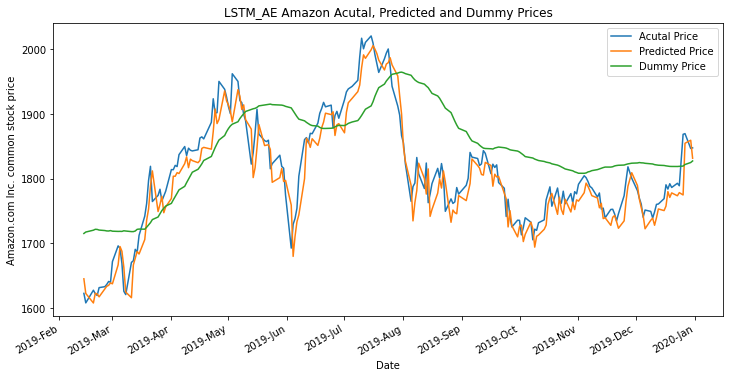

In [17]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

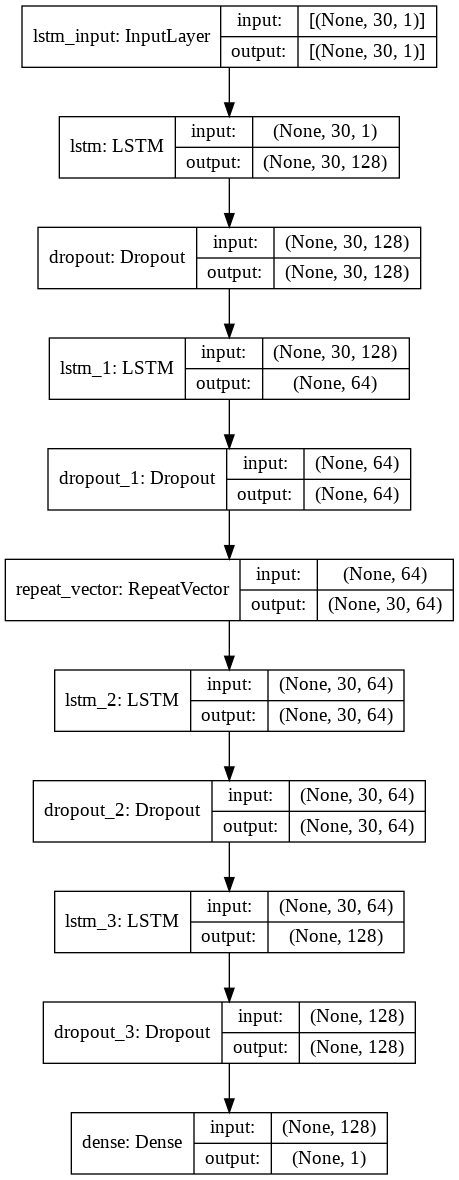

In [18]:
plot_model(model, show_shapes=True, expand_nested=True)

In [19]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.011176807743471453
RMSE:  0.10572042254678825
MAE:  0.08875960198914791
Dummy MSE:  0.03412892153519778
Dummy RMSE:  0.18474014597590255
Dummy MAE:  0.1546333417475681


In [20]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Amazon/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Amazon/assets
